# Hierarchical optimization

In this notebook we illustrate how to do hierarchical optimization in pyPESTO.

A frequent problem occuring in parameter estimation for dynamical systems is that the objective function takes a form

$$ J(\theta, s, b, \sigma^2) = \sum_i \left[\log(2\pi\sigma_i^2) + \frac{(\bar y_i - (s_iy_i(\theta) + b_i))^2}{\sigma_i^2}\right] $$

with data $\bar y_i$, parameters $\eta = (\theta,s,b,\sigma^2)$, and ODE simulations $y(\theta)$. Here, we consider a Gaussian noise model, but also others (e.g. Laplace) are possible. The point of interest here is that we can split up the parameter vector $\eta$ into "dynamic" parameters $\theta$ which are required for simulating the ODE, and "static" parameters $s,b,\sigma^2$ only required to scale the simulations and formulate the objective function. As usually simulating the ODE is the time-critical part, one can exploit this separation of parameters by formulating an outer optimization problem in which $\theta$ is optimized, and an inner optimization problem in which $s,b,\sigma^2$ are optimized conditioned on $\theta$. This approach has shown to have superior performance to the classic aproach of jointly optimizting $\eta$. 

In pyPESTO, we have implemented the algorithms developed in [Loos et al.; Hierarchical optimization for the efficient parametrization of ODE models; Bioinformatics 2018](https://academic.oup.com/bioinformatics/article/34/24/4266/5053308) (covering Gaussiain and Laplace noise models with gradients computed via forward sensitivity analysis) and [Schmiester et al.; Efficient parameterization of large-scale dynamic models based on relative measurements; Bioinformatics 2019](https://academic.oup.com/bioinformatics/article/36/2/594/5538985) (extending to offset parameters and adjoint sensitivity analysis).

How to use

In [1]:
import pypesto
import amici
import petab
import time

from pypesto.hierarchical.solver import AnalyticalInnerSolver, NumericalInnerSolver

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# a collection of models that can be simulated

folder_base = "/home/yannik/benchmark-models-petab/Benchmark-Models"
model_name = "Zheng_PNAS2012"
model_name = "Boehm_JProteomeRes2014"
#model_name = "Fujita_SciSignal2010"
#model_name = "Sneyd_PNAS2002"
#model_name = "Borghans_BiophysChem1997"
#model_name = "Elowitz_Nature2000"
#model_name = "Crauste_CellSystems2017"
#model_name = "Lucarelli_CellSystems2018"
#model_name = "Schwen_PONE2014"
#model_name = "Blasi_CellSystems2016"
#model_name = "Chen_MSB2009"

# the yaml configuration file links to all needed files
yaml_config = os.path.join(folder_base, model_name, model_name + '.yaml')

# create a petab problem
petab_problem = petab.Problem.from_yaml(yaml_config)

In [3]:
importer = pypesto.PetabImporter(petab_problem)

model = importer.create_model()

import libsbml
converter_config = libsbml.SBMLLocalParameterConverter()\
    .getDefaultProperties()
petab_problem.sbml_document.convert(converter_config)

0

In [4]:
objective = importer.create_objective(hierarchical=True)
problem = importer.create_problem(objective)
problem.objective.amici_solver.setSensitivityMethod(amici.SensitivityMethod_adjoint)

objective2 = importer.create_objective(hierarchical=False)
problem2 = importer.create_problem(objective2)
problem2.objective.amici_solver.setSensitivityMethod(amici.SensitivityMethod_adjoint)

n_starts = 200
startpoints = pypesto.startpoint.latin_hypercube(n_starts=n_starts, lb=problem2.lb, ub=problem2.ub)
problem.x_guesses = startpoints[:, :-6]
problem2.x_guesses = startpoints

In [5]:
start_time = time.time()
problem.objective.calculator.inner_solver = NumericalInnerSolver()
problem.objective.calculator.inner_solver.n_starts = 1
engine = pypesto.MultiProcessEngine(n_procs=6)
result_num = pypesto.minimize(problem, n_starts=n_starts, engine=engine)
print(result_num.optimize_result.get_for_key('fval'))
time_num = time.time() - start_time
print(time_num)

Parameters obtained from history and optimizer do not match: [7.70083856e+00 1.13777892e+04 8.14904366e+00 6.55473659e+01
 2.71588363e+04 1.84720079e+00], [7.70023891e+00 1.13782584e+04 8.14927198e+00 6.55468309e+01
 2.71591751e+04 1.84711931e+00]
Parameters obtained from history and optimizer do not match: [1.41777057e+03 5.86771626e+02 8.15210478e+00 9.99981582e+04
 9.99988723e+04 1.84680529e+00], [1.41778349e+03 5.86782221e+02 8.15208075e+00 9.99981586e+04
 9.99988727e+04 1.84680423e+00]
Parameters obtained from history and optimizer do not match: [8.38926518e+03 2.03354974e+03 8.18200641e+00 1.31688076e+04
 5.45958732e+03 1.85204331e+00], [8.38936374e+03 2.03354952e+03 8.18200615e+00 1.31688103e+04
 5.45960825e+03 1.85204427e+00]
Parameters obtained from history and optimizer do not match: [1.27255009e+01 1.57075208e+01 8.18100959e+00 1.47604437e+04
 2.57706629e+04 1.85211220e+00], [1.27256735e+01 1.57074918e+01 8.18098180e+00 1.47603727e+04
 2.57706525e+04 1.85211060e+00]
Paramete

[131.6255511428638, 131.62596905401895, 131.6261080710828, 131.63795742486224, 132.35168247326283, 132.3516880615208, 132.3517105559876, 134.1468440458901, 134.18770600028395, 134.1946915004884, 134.20450504550752, 134.44289341884942, 134.44289491685876, 134.44295368953928, 134.44435593624678, 134.4447469998343, 134.44483771402082, 135.15244547133497, 136.2152856049668, 136.21529195766232, 136.21530415594955, 136.21627309182662, 136.2196102311901, 136.22444029990527, 136.22446048202673, 136.22447848787507, 136.2247022208248, 136.227746494153, 136.23063361469875, 136.23131191828372, 138.33911987404565, 138.33935231061727, 138.37691294801067, 138.37696445655237, 139.03675458586386, 142.7045851696458, 143.80646098319005, 143.8064708974246, 143.8066485311845, 143.8104695875127, 143.82090889475114, 143.82158858981296, 143.82253888483586, 147.01390311217838, 147.0158963976475, 147.23795523197634, 147.34821656721937, 150.31057108440356, 150.31426541817325, 153.50045156400031, 160.212603376741

In [6]:
start_time = time.time()
problem.objective.calculator.inner_solver = AnalyticalInnerSolver()
engine = pypesto.MultiProcessEngine(n_procs=6)
result_ana = pypesto.minimize(problem, n_starts=n_starts, engine=engine)
print(result_ana.optimize_result.get_for_key('fval'))
time_ana = time.time() - start_time
print(time_ana)

[131.62554604019314, 131.62554776750545, 131.62555746281862, 131.62696435197327, 131.6269992396104, 132.35167456995615, 132.35167537879536, 132.35167542667622, 132.3516759459162, 132.35168268256848, 132.3516867787422, 132.35172577549162, 132.35191955989586, 134.18520162433498, 134.18614486744622, 134.1863868700961, 134.19474241040623, 134.20479922489213, 134.44289231891904, 134.4428947812641, 134.4428972139463, 134.44297670594568, 134.44353138410176, 134.44476103788614, 134.44491460171807, 136.2152840447786, 136.2152881985772, 136.2153385727625, 136.215384562948, 136.2164238160583, 136.2164894188362, 136.21961121553477, 136.2244383749905, 136.22486955015438, 136.23077728795928, 138.3391929347809, 139.03669136329611, 139.0404193214127, 139.05074709939842, 142.70458441454144, 142.70458475252804, 142.70458477741738, 142.70459316140835, 142.7046155697222, 143.80670556290656, 143.81837292217435, 143.8216955841304, 147.01349879345648, 147.01349887185282, 147.01451532584773, 150.0847008409193

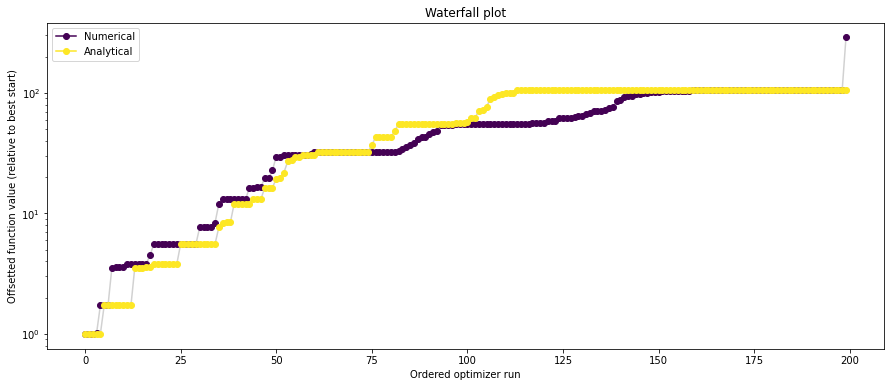

In [13]:
pypesto.visualize.waterfall([result_num, result_ana], legends=['Numerical', 'Analytical'], size=(15,6))
plt.savefig("num_ana.png")

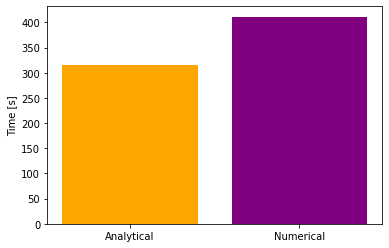

In [17]:
import matplotlib.pyplot as plt
ax = plt.bar(x=[0,1], height=[time_ana, time_num], color=['orange', 'purple'])
ax = plt.gca()
ax.set_xticks([0,1])
ax.set_xticklabels(['Analytical', 'Numerical'])
ax.set_ylabel('Time [s]')
plt.savefig("num_ana_time.png")

In [8]:
start_time = time.time()
engine = pypesto.MultiProcessEngine(n_procs=6)
result_ord = pypesto.minimize(problem2, n_starts=n_starts, engine=engine)
print(result_ord.optimize_result.get_for_key('fval'))
time_ord = time.time() - start_time
print(time_ord)

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 6.43784e-05 and h = -2.03494e-11, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:CVODEA:CVodeB:ERR_FAILURE: AMICI ERROR: in module CVODEA in function CVodeB : Error occured while integrating backward problem # 0 
[Warning] AMICI:simulation: AMICI backward simulation failed when trying to solve until t = 0.000000 (see message above):
AMICI failed to integrate the backward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.020267, mxstep steps taken before reaching tout. 
[Warning] AMICI:CVODEA:CVodeB:TOO_MUCH_WORK: AMICI ERROR: in module CVODEA in function CVodeB : Error occured while integrating backward problem # 0 
[Warning] AMICI:simulation: AMICI backward simulation failed when trying to solve until t = 0.000000 (see message above):
AMICI failed to integrate the backward problem

[Warning] AMICI:NaN: A

[131.625549968007, 131.625749024864, 132.35168649527034, 134.1852151278731, 134.18523025572773, 134.1852487024338, 134.18976377032905, 134.20451730128292, 134.44290002491553, 134.44290023341668, 134.44302620288255, 134.4430927887039, 134.44310613509896, 134.44472589522678, 135.8649566311314, 136.07519083988723, 136.21530911880882, 136.21531123659324, 136.21532529557237, 136.21557550588128, 136.21578787102067, 136.21989507514903, 136.2208992356445, 136.2244717299167, 136.22448025591092, 136.22960825003003, 138.37677671053245, 139.04181616772874, 143.8217767781375, 145.19383401277537, 147.01589296818221, 147.01591227853712, 147.57301565125277, 150.20639506227425, 151.1882474912191, 162.9263829785691, 168.46183868613133, 168.47686023853186, 170.31169037650386, 170.37210329543916, 170.69498260366979, 170.89694055666402, 171.92837249909778, 171.93223294716933, 171.95427064445855, 172.5055046980844, 173.97208454543528, 174.3898606898721, 175.09957160865153, 175.11071066944405, 179.9497568536

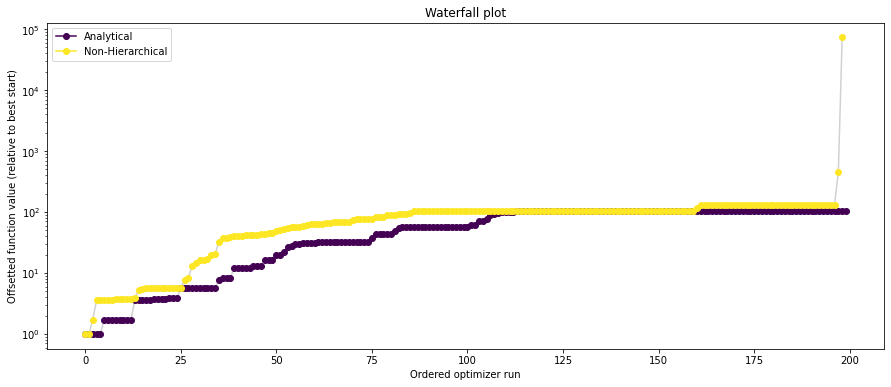

In [18]:
pypesto.visualize.waterfall([result_ana, result_ord], legends=['Analytical', 'Non-Hierarchical'], size=(15,6))
plt.savefig("ana_ord.png")

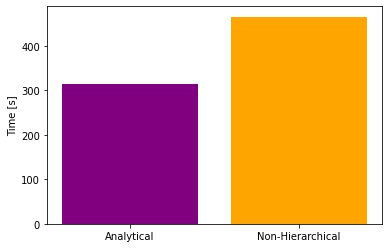

In [19]:
#t_ana = 183.50705766677856
#t_std = 305.25369572639465

import matplotlib.pyplot as plt
ax = plt.bar(x=[0,1], height=[time_ana, time_ord], color=['purple', 'orange'])
ax = plt.gca()
ax.set_xticks([0,1])
ax.set_xticklabels(['Analytical', 'Non-Hierarchical'])
ax.set_ylabel('Time [s]')
plt.savefig("ana_ord_time.png")

In [11]:
start_time = time.time()
problem.objective.calculator.inner_solver = AnalyticalInnerSolver()
problem.objective.amici_solver.setSensitivityMethod(amici.SensitivityMethod_forward)
engine = pypesto.MultiProcessEngine(n_procs=6)
result_ana_fw = pypesto.minimize(problem, n_starts=n_starts, engine=engine)
print(result_ana_fw.optimize_result.get_for_key('fval'))
time_ana_fw = time.time() - start_time
print(time_ana_fw)

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 151.419 and h = 2.83453e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 151.418547:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 14.1229 and h = 3.09597e-06, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 14.122891:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 14.1229 and h = 3.09597e-06, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 14.122891:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in fun

[131.62554698717543, 131.62554798812096, 131.6255489454112, 131.62625365520643, 132.3516743642284, 132.35167494134413, 132.35167834090512, 132.35172537543394, 132.38009223558092, 134.18520020550537, 134.1852064277978, 134.18614094970428, 134.1877015965612, 134.2045025211904, 134.2045028272634, 134.2045839210075, 134.2048003210254, 134.44289960618687, 134.44292158836643, 134.4432013496905, 134.44337879317663, 134.44476072845833, 134.44627398346353, 136.21528089081937, 136.21625327155172, 136.22443418804738, 136.22446349957286, 136.2272298888613, 136.84820458201577, 137.30832950021355, 138.33919250321975, 139.216330320719, 140.12976934305047, 142.70458489339785, 142.70458583642096, 142.70461006687825, 142.70461628537907, 143.80646269134644, 143.82114101982395, 143.82169553028666, 143.82277204746168, 145.194414252061, 147.01350801568637, 147.01390229357847, 147.2760114614004, 147.78374429184356, 147.78376343805687, 150.3105607925258, 151.1476101092348, 158.67739122324568, 160.214229772813

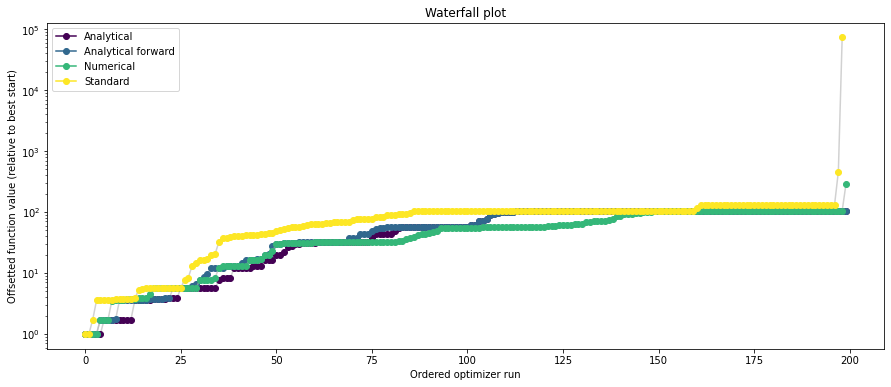

In [20]:
pypesto.visualize.waterfall([result_ana, result_ana_fw, result_num, result_ord], legends=['Analytical', 'Analytical forward', 'Numerical', 'Standard'], size=(15,6))
plt.savefig("all.png")

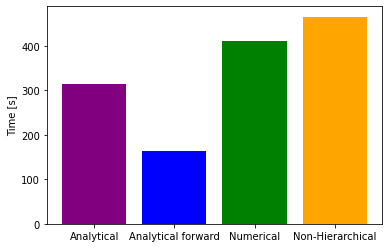

In [22]:
import matplotlib.pyplot as plt
ax = plt.bar(x=[0,1,2,3], height=[time_ana, time_ana_fw, time_num, time_ord], color=['purple', 'blue', 'green', 'orange'])
ax = plt.gca()
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['Analytical', 'Analytical forward', 'Numerical', 'Non-Hierarchical'])
ax.set_ylabel('Time [s]')
plt.savefig("all_time.png")

In [16]:
problem.objective.calculator.inner_problem.get_x_ids()

['sd_pSTAT5A_rel',
 'sd_pSTAT5B_rel',
 'sd_rSTAT5A_rel',
 'scaling_pSTAT5A_rel',
 'scaling_pSTAT5B_rel',
 'scaling_rSTAT5A_rel']

In [19]:
objective = importer.create_objective(hierarchical=True)
problem = importer.create_problem(objective=objective)

objective2 = importer.create_objective(hierarchical=False)
problem2 = importer.create_problem(objective=objective2)

startpoints = pypesto.startpoint.latin_hypercube(n_starts=100, lb=problem2.lb, ub=problem2.ub)
problem.x_guesses = startpoints[:, :-3]
problem2.x_guesses = startpoints

In [20]:
engine = pypesto.MultiProcessEngine(n_procs=4)
result = pypesto.minimize(problem, n_starts=100, engine=engine)

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 209.94 and h = 3.44641e-06, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 209.940335:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value a

In [21]:
engine = pypesto.MultiProcessEngine(n_procs=4)
result2 = pypesto.minimize(problem2, n_starts=100, engine=engine)

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 209.94 and h = 3.44641e-06, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 209.940335:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value a

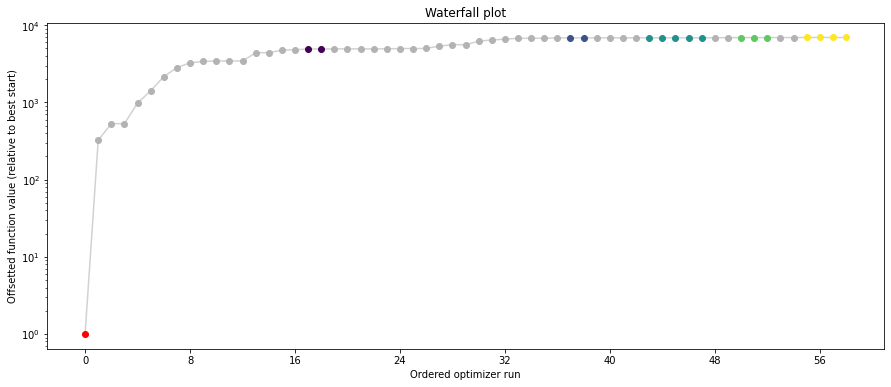

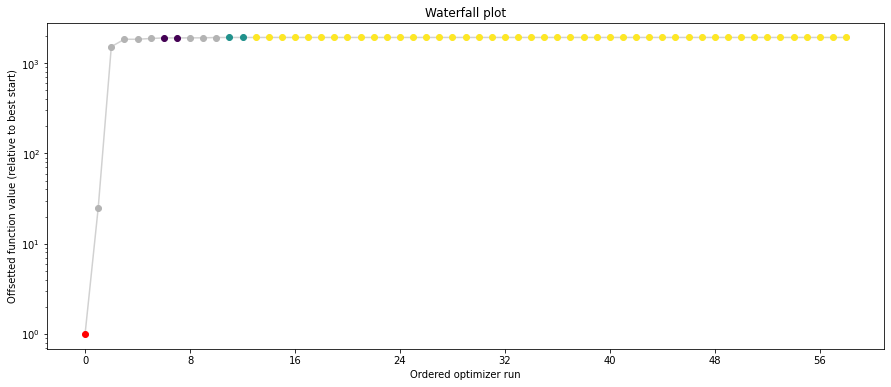

In [22]:
pypesto.visualize.waterfall(result, size=(15,6))
pypesto.visualize.waterfall(result2, size=(15,6))

In [23]:
result.optimize_result.get_for_key('fval')

[3069.930642008128,
 3393.478312520467,
 3599.095150899836,
 3599.6270282335677,
 4051.30511265327,
 4484.297526066286,
 5230.389128438384,
 5890.628295320637,
 6336.91846141333,
 6463.253337660664,
 6508.68069475996,
 6512.030756846749,
 6515.1259837798425,
 7462.444615271462,
 7484.144488643876,
 7814.975974417747,
 7880.354030137594,
 7994.394642288837,
 7994.413018506659,
 8008.302864220714,
 8011.014423887539,
 8012.090044523172,
 8012.352107687674,
 8016.1380259164025,
 8054.475301208518,
 8061.600495863766,
 8074.497619031203,
 8438.061508273604,
 8661.751136871824,
 8664.575321509785,
 9287.99923593938,
 9507.776762860833,
 9665.156028070332,
 9839.459054042498,
 9844.018514304014,
 9862.803420500026,
 9909.456686699696,
 9924.87013655223,
 9924.870217397254,
 9925.17602380901,
 9928.54349574456,
 9937.90677240958,
 9939.001638737285,
 9942.833790885876,
 9942.872079983586,
 9942.872101288065,
 9942.872103221158,
 9942.872103285961,
 9963.220643334344,
 9969.578166182333,
 9989

In [24]:
result2.optimize_result.get_for_key('fval')

[8081.474368872647,
 8105.346565678689,
 9608.451297409823,
 9924.870136097603,
 9925.176023816422,
 9961.463384094608,
 9989.286898176797,
 9989.286937611374,
 9991.031590073537,
 9993.208134879049,
 10009.400416393535,
 10010.553867134258,
 10010.58848989653,
 10011.532027874398,
 10011.53218467507,
 10011.532232676234,
 10011.53228436675,
 10011.532293945453,
 10011.532294255028,
 10011.532294255032,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 1001

In [8]:
print(sum(result.optimize_result.get_for_key('time')))
print(sum(result2.optimize_result.get_for_key('time')))

240.8520963191986
296.93090653419495
